# INTEG 475 Final Project: Biasedness of Useful Votes in Yelp Reviews

|Name        | Student ID|
|------------|-----------|
|Arumoy Shome| 20460621  |
|Shruti Rao  | 20455421  |

## Introduction

From its humble beginings as an email based referral network for doctors, Yelp has evolved into a billion dollar  publisher of crowd-sourced reviews about local businesses. Within Yelp, the value of a business depends directly on the information provided by users in the form of written reviews and photos. Potential customers can then view these user reviews and make more informed decisions about using a particular service provided by a business.

To make user reviews more reliable for others, Yelp introduced a system of rating these user reviews as well. A user can manually upvote reviews as `useful` to indicate to other users that this piece of text provided meaningful information about a business from their perspective. However, relying on users to manually indicate utility can introduce bias that is unrelated to the actual relevance of the review text. For local businesses and users who are increasingly reliant on such systems over traditional food critiques, the legitimacy of a review can make or break an experience. 

The idea of usefulness is a complicated one, affected by user’s perception and needs. In the case of online reviews, the utility of the text to a user is how well it provides relevant information about the interaction with the business in question. However, because different users have different needs, the value of the supposed relevant information within a review will differ. For a system like Yelp, while user labels of value can provide an additional layer of filtering, it is clear that differences exist in exactly how “usefulness” can be defined between individuals. 

In this project, first a benchmark model is created to predicts a review’s “usefulness” based on review-text. Other models that incorporate other non-review-text related features are then created and compared against the benchmark in order to identify if bias exists when users manually label reviews as “useful”. If bias does exist, knowing the specific features that cause this can be used to better tweak Yelp’s ecosystem to surface unbiased information for users.
    
    
## Research Question
Do users actually read a review before voting it useful or is their influenced by the presence of previsouly registered `cool`, `funny` and `useful` votes.


## Background
There exists a large amount of existing research about online reviews based on the Yelp dataset. The dataset itself is open source and updated with new data annually, encouraging new developments in the review analysis space each year [8]. 

A literature review found that while there are a variety of different techniques [9] [10] being used to analyze review data, random forest classifiers are incredibly popular [11] [12]. One group used Bag-of-Words on review data  combined with features from user and business datasets to predict the required numeric value of the “usefulness” of a review with a batch mode localized weighted regression model. This localized regression approach resulted into RMSLE of 0.47769 [9]. Others compared SVM with logistic regression with Lasso to identify that the latter was the best with lower training error [10]. However, in comparison, using a random forest model with 150 estimators, the square root of original feature numbers to get maximum features, with ten minimum number of leaves to split, and no maximum depth lead to a model accuracy of 0.698926 [11]. Further improvements using random forest prediction with five fold cross validation were able to achieve an accuracy rate of 79% [12].  Another group took this even further and was able to achieve 95% accuracy in correctly labelling a review as useful using this random forest classifier approach [13]. 

In parallel with this research into predicting the “usefulness” of a review is developing an understanding of what skews bias in online reviews. Studies use Amazon and Yelp data to look at what features specific to these two ecosystems cause bias in user perception of review value. Typically, a review is seen relative to other reviews. In a study using over 4 million Amazon book reviews for roughly 675 000 books, the perceived usefulness of reviews was dependent on its relationship to other reviews, not only its content [14]. Information about the reviewer themselves can also affect the perceived utility of a review [15]. Yelp restaurant reviews had their “usefulness” affected by user-based features more than detailed information within the review about the features of the restaurant [16]. More specifically, another group looking at over 72 000 Yelp reviews found that neutral and negative reviews by locals were seen as more useful, even if the information within the review was not necessarily valuable [17].

The novelty of this paper is found in the granular approach to which Yelp dataset-specific features are considered. Instead of a broad generalization of what creates bias, the focus is on features with high correlation with review “usefulness” in order to understand if they bias users.


# Analysis

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC


from scipy.sparse import csr_matrix, csc_matrix, hstack, vstack
SAMPLE_SIZE = 5000

In [92]:
reviews = pd.read_csv('dataset/review.csv', usecols=['text', 'useful', 'cool'])

We need to make sure that we have equal number of data points for each label. We will label a review `useful` if it has received 1 or more `useful` votes, and those with votes lesser than 1 as *not useful*.

The following cell randomly samples for a predefined number (defined by `SAMPLE_SIZE`) of *useful* and *not useful* reviews. The dataframes are then concatenated together and the resulting df is then shuffled.

In [93]:
THRESHOLD = 1 

useful_reviews = reviews.loc[reviews['useful'] >= THRESHOLD].sample(SAMPLE_SIZE)
not_useful_reviews = reviews.loc[reviews['useful'] < THRESHOLD].sample(SAMPLE_SIZE)
print("useful_reviews shape: ", useful_reviews.shape)
print("not_useful_reviews shape: ", not_useful_reviews.shape)

reviews = shuffle(pd.concat([useful_reviews, not_useful_reviews]))
reviews.head()

useful_reviews shape:  (5000, 3)
not_useful_reviews shape:  (5000, 3)


,text,useful,cool
4340862,I can't begin to explain what an amazing place...,0,0
3708364,I found Jen at Essentials on Yelp after one so...,0,0
1827027,Came in here for for a quick beer. Bartenders ...,0,0
1636168,Absolutely amazing selection and variety of pl...,2,2
3839785,"Use to love this place , hadn't been here in a...",0,0


## Preprocessing

For `text` a custom `analyzer` method namely `review_process` is written which:
1. removes all punctuations and
3. removes new line characters (escape sequence)

The feature extraction (`TfidfVectorizer`) class is then set to:
2. remove accents
2. remove all stopwords
3. lowercase all words

For `useful` votes:
2. remove df row if `useful` is `NaN`

In [94]:
reviews.dropna(inplace=True)
print("reviews shape after dropping NaN values: ", reviews.shape)

reviews shape after dropping NaN values:  (10000, 3)


In [95]:
import string
import re

RE_NEWLINE = '\n+'
PUNCTUATIONS = string.punctuation

def review_process(review):
    no_newline = re.sub(RE_NEWLINE, '', review)
    no_punc = ''.join([char for char in no_newline if char not in PUNCTUATIONS])
    
    return no_punc

In [96]:
test = "a str.. with! some @2 punctuations 6546721 and numbers \n [] \n"
print(review_process(test))

a str with some 2 punctuations 6546721 and numbers   


In [97]:
vect = TfidfVectorizer(strip_accents='ascii', preprocessor=review_process, stop_words='english' )
vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<function review_process at 0x183a10a60>,
        smooth_idf=True, stop_words='english', strip_accents='ascii',
        sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, use_idf=True, vocabulary=None)

## Generating labels

We assign a label of **1** to reviews that are *useful* and a label of **0** to those which are *not useful*.

In [98]:
import math

NOT_USEFUL = 0
USEFUL = 1

def labeler(vote):
    if math.floor(vote) < THRESHOLD:
        return NOT_USEFUL
    else:
        return USEFUL

In [99]:
reviews['label'] = reviews['useful'].apply(labeler)
    
reviews.head()

,text,useful,cool,label
4340862,I can't begin to explain what an amazing place...,0,0,0
3708364,I found Jen at Essentials on Yelp after one so...,0,0,0
1827027,Came in here for for a quick beer. Bartenders ...,0,0,0
1636168,Absolutely amazing selection and variety of pl...,2,2,1
3839785,"Use to love this place , hadn't been here in a...",0,0,0


## Cross validation

We will use K-fold validation with 5 folds using `cross_val_score` from `sklearn.model_selection` which by default used K-fold validation. `cross_val_score` trains and validates the classifier with *k-1* folds and tests with the remaining fold which means we do not have to create testing and training splits manually.

In [100]:
X = reviews[['text', 'useful', 'cool']]
Y = reviews['label']

In [101]:
def print_percent(flt):
    pretty = "%.2f" % (flt*100)
    
    return "{0}%".format(pretty)

## Instantiate classifiers

We will be using 3 classifiers for this analysis namely, *Multinomial Naive Bayes*, *Linear SVM* and *Random Forest*. These classifiers were choosen as they were the most frequent choices in several papers written on the matter. **REF**

In [102]:
mn_clas = MultinomialNB()
print(mn_clas)
print("\n")

svc_clas = LinearSVC()
print(svc_clas)
print("\n")

rf_clas = RandomForestClassifier()
print(rf_clas)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


## Feature selection

As we increase the number of data points, the vocabulary of our classifiers will increase which means the number of features extracted will also increase. For a large number of data points, this will be memory intensive and will also result in longer training time.

To improve the performance of our program, we will remove all zero-variance features.

In [105]:
# doesn't work, remove?
sel = VarianceThreshold()
sel

VarianceThreshold(threshold=0.0)

## Model 1: training with only text

In [104]:
# feature extraction
X1 = vect.fit_transform(X['text'])
print("shape of X1 after feature extraction: ", X1.shape)

shape of X1 after feature extraction:  (10000, 49085)


In [75]:
type(X1)

scipy.sparse.csr.csr_matrix

In [110]:
print("Naive Bayes score: ", print_percent(mn_valid_scores.mean()))
print("Linear SVC score: ", print_percent(svc_valid_scores.mean()))
print("Random Forest score: ", print_percent(rf_valid_scores.mean()))

Naive Bayes score:  57.45%
Linear SVC score:  56.80%
Random Forest score:  57.79%


## Model 2: training with text and useful votes

Since X now contains mixed dtypes, we need to be a bit clever. First, we convert `useful` column for train and test into sparse matrix and *I2* normalize them (I2 is the default for `TfidfVectorizer` so that's what we use here as well).

The rest is straight forward, we create our updated X by stacking the `useful` sparse matrices with X horizontally (such that the number of feature increases). 

In [18]:
useful_sparse_train = normalize(csr_matrix(X['useful']))
print("type of useful_sparse_train: ", type(useful_sparse_train))
print("shape of useful_sparse_train: ", useful_sparse_train.shape)

type of useful_sparse_train:  <class 'scipy.sparse.csr.csr_matrix'>
shape of useful_sparse_train:  (1, 10000)


In [19]:
X2 = hstack([X1, useful_sparse_train.T])
print("shape of X2: ", X2.shape)

shape of X2:  (10000, 48400)


In [20]:
mn_scores = cross_val_score(mn_clas, X2, Y, cv=5)
svc_scores = cross_val_score(svc_clas, X2, Y, cv=5)
rf_scores = cross_val_score(rf_clas, X2, Y, cv=5)

In [21]:
print("Naive Bayes score: ", print_percent(mn_scores.mean()))
print("Linear SVC score: ", print_percent(svc_scores.mean()))
print("Random Forest score: ", print_percent(rf_scores.mean()))

Naive Bayes score:  58.07%
Linear SVC score:  63.15%
Random Forest score:  84.49%


## Model 3: training with text and cool votes

Next we will carry out the analysis with text and `cool` votes. We choose `cool` votes since it had the second highest correlation with `useful` (see exploration.ipynb).

In [22]:
cool_sparse_train = normalize(csr_matrix(X['cool']))

In [23]:
X3 = hstack([X1, cool_sparse_train.T])
print("shape of X3: ", X3.shape)

shape of X3:  (10000, 48400)


In [24]:
mn_scores = cross_val_score(mn_clas, X3, Y, cv=5)
svc_scores = cross_val_score(svc_clas, X3, Y, cv=5)
rf_scores = cross_val_score(rf_clas, X3, Y, cv=5)

In [25]:
print("Naive Bayes score: ", print_percent(mn_scores.mean()))
print("Linear SVC score: ", print_percent(svc_scores.mean()))
print("Random Forest score: ", print_percent(rf_scores.mean()))

Naive Bayes score:  57.66%
Linear SVC score:  59.56%
Random Forest score:  65.06%


## Model 4: training with text, useful and cool votes

Finally we will carry out the analysis with text, `useful` & `cool` votes.

In [111]:
uc_sparse_train = normalize(csr_matrix(X[['cool', 'useful']]))
print("shape of uc_sparse_train: ", uc_sparse_train.shape)

shape of uc_sparse_train:  (10000, 2)


In [112]:
X4 = hstack([X1, uc_sparse_train])
print("shape of X4: ", X4.shape)

shape of X4:  (10000, 49087)


In [113]:
mn_scores = cross_val_score(mn_clas, X4, Y, cv=5)
svc_scores = cross_val_score(svc_clas, X4, Y, cv=5)
rf_scores = cross_val_score(rf_clas, X4, Y, cv=5)

In [114]:
print("Naive Bayes score: ", print_percent(mn_scores.mean()))
print("Linear SVC score: ", print_percent(svc_scores.mean()))
print("Random Forest score: ", print_percent(rf_scores.mean()))

Naive Bayes score:  82.10%
Linear SVC score:  99.99%
Random Forest score:  86.41%


## Summary

The goal of this project was to determine whether `useful` votes received by reviews on Yelp are biased. To understand the presence of any such relationship, we carried out training in four stages:
1. To establish a benchmark, we carried out supervised learning of our model on the text of reviews.
2. Next, the useful votes previously received by reviews are also added during training.
3. For the third model, we trained with review text and `cool` votes which has the highest correlation with `useful` votes.
4. Finally, for the fourth model we trained with text, `useful` and `cool` votes.

**We observed that reviews that obtained a previously high number of `useful` votes were more likely to be voted `useful` in the future.**
Model 1 and Model 3 share similar scores implying that `cool` votes dont cause too much bias towards usefulness of a review.
Finally, Model 4 had the highest scores meaning `useful` and `cool` votes together cause maximum bias.


| Models | Multinomial Naive Bayes| Linear SVM| Random Forest|
|--------|------------------------|-----------|--------------|
| Model 1|57.45%                  |56.80%     |57.79%        |
| Model 2|58.07%                  |63.15%     |84.49%        |
| Model 3|57.66%                  |59.56%     |65.06%        |
| Model 4|82.10%                  |99.99%     |86.41%        |


## Recommendations

After feature extraction. feature selection will be helpful once the number of data points increases. This will be due to the fact that it will improve the performance of the classifier by reducing the learning time.

Feature selection is a process whereby certain features within the model with low variance are removed. This is useful for us for the following reasons:
* reduces the training time of our classifiers
* reduces overfitting by generalizing the model
* reduces the complexity of the model as there are less features to deal with

---> TODO: Cite sources

2. Improve label generation by using k-means to identify the labels
_Note_: explain how we are generating label atm

Presently a Naive methodology has been used to determine the labels for the useful votes. A better solution would be to use k-means to determine appropriate labels on the useful votes.

---> TODO: Cite Sources
_Note_: Code TODO- identify bug in this process

In [1]:
mn_train_sizes, mn_train_scores, mn_valid_scores = learning_curve(mn_clas, X4, Y, cv=5)
svc_train_sizes, svc_train_scores, svc_valid_scores = learning_curve(svc_clas, X4, Y, cv=5)
rf_train_sizes, rf_train_scores, rf_valid_scores = learning_curve(rf_clas, X4, Y, cv=5)

NameError: name 'learning_curve' is not defined

In [116]:
learning_curve_data = {'Multinomial Bayes': [mn_train_sizes, mn_train_scores, mn_valid_scores],
                       'Linear SVM': [svc_train_sizes, svc_train_scores, svc_valid_scores],
                       'Random Forest': [rf_train_sizes, rf_train_scores, rf_valid_scores]}

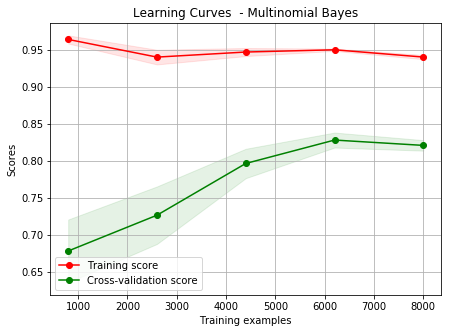

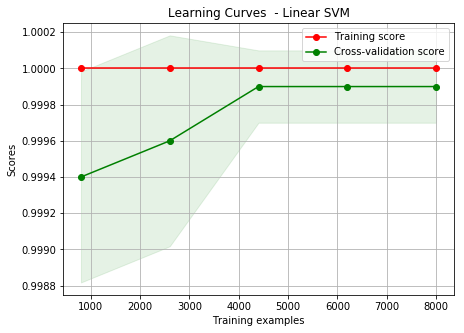

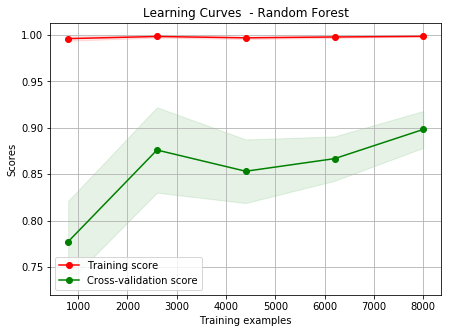

In [117]:
for name, data in learning_curve_data.items():
    plt.figure()
    plt.figure(figsize=(7,5))
    plt.title("Learning Curves  - {0}".format(name))

    plt.xlabel("Training examples")
    plt.ylabel("Scores")

    train_scores_mean = np.mean(data[1], axis=1)
    train_scores_std = np.std(data[1], axis=1)

    test_scores_mean = np.mean(data[2], axis=1)
    test_scores_std = np.std(data[2], axis=1)

    plt.grid()

    plt.fill_between(data[0], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(data[0], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(data[0], train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(data[0], test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")

## References:

